In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [21]:
# ------------ now made respectable :) ---------------

In [22]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [90]:
#mlp revisited
n_embd = 10
n_hidden=200

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5)
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))



parameters = [C, W1, b1, W2, b2, bngain, bnbias, bnmean_running, bnstd_running]

In [91]:
sum(p.nelement() for p in parameters) # number of parameters in total

12697

In [92]:
for p in parameters:
  p.requires_grad = True

In [93]:
(torch.randn(10000)*0.2).std()
(5/3) / (300**0.5)

0.09622504486493762

In [97]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [98]:
lri = []
lossi = []
stepi = []

In [103]:
import torch
import torch.nn.functional as F

# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X,Y

    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1# + b1  # hidden layer pre-activation

    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)  # hidden layer
    logits = h @ W2 + b2  # output layer
    loss = F.cross_entropy(logits, Yb)  # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < n_iterations // 2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

    # Print progress
    if i % (n_iterations // 10) == 0:
        print(f"Progress: {int(i / n_iterations * 100)}% | Loss: {loss.item():.4f}")

print("Final loss:", loss.item())

Progress: 0% | Loss: 3.3147
Progress: 10% | Loss: 2.2458
Progress: 20% | Loss: 1.9122
Progress: 30% | Loss: 2.5749
Progress: 40% | Loss: 2.2734
Progress: 50% | Loss: 2.0688
Progress: 60% | Loss: 2.0006
Progress: 70% | Loss: 2.4521
Progress: 80% | Loss: 2.0944
Progress: 90% | Loss: 2.1936
Final loss: 2.3535075187683105


In [113]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.10249400138855
val 2.1327953338623047


In [115]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.5817, grad_fn=<NllLossBackward0>)

In [116]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.6328, grad_fn=<NllLossBackward0>)

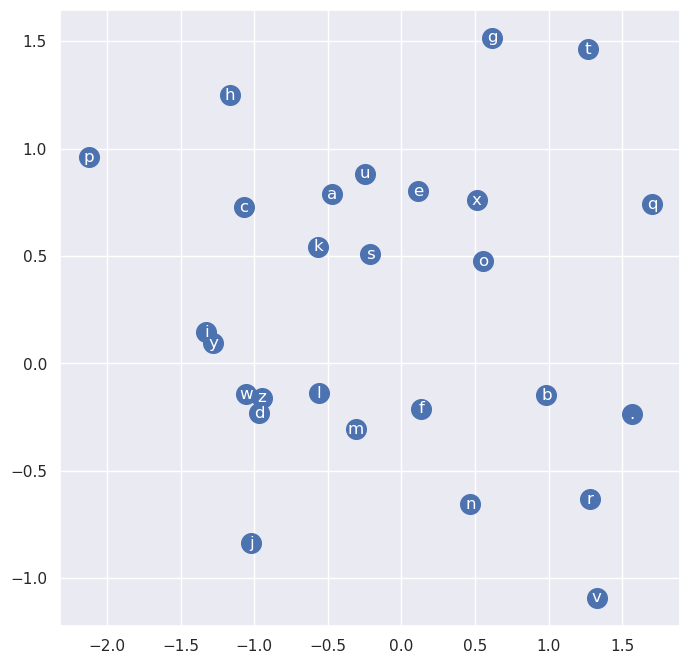

In [117]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [118]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

In [119]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [120]:


# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

marabighan.
syd.
madhan.
marithraj.
jernegan.
chaddelithell.
jed.
maristan.
maricky.
kollyn.
marshiberishim.
emrit.
jossellynn.
prose.
belled.
roy.
jud.
marylah.
maric.
daihan.


In [45]:
import torch
import torch.nn as nn

# Create a tensor with shape (3, 4) (e.g., a linear layer with 3 inputs and 4 outputs)
tensor = torch.empty(3, 4)

# Initialize the tensor with Kaiming normal distribution
nn.init.kaiming_normal_(tensor)

print(tensor)

tensor([[-0.1683,  1.1305,  0.4766, -0.6504],
        [-1.4722,  0.4214,  0.5993,  0.9660],
        [ 0.3376,  0.6153, -0.0177,  0.0582]])


In [64]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple neural network without batch normalization
class NetNoBN(nn.Module):
    def __init__(self):
        super(NetNoBN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # input layer (28x28 images) -> hidden layer (128 units)
        self.fc2 = nn.Linear(128, 10)  # hidden layer (128 units) -> output layer (10 units)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # activation function for hidden layer
        x = self.fc2(x)
        return x

# Define a simple neural network with batch normalization
class NetBN(nn.Module):
    def __init__(self):
        super(NetBN, self).__init__()
        self.fc1 = nn.Linear(784, 128)  # input layer (28x28 images) -> hidden layer (128 units)
        self.bn1 = nn.BatchNorm1d(128)  # batch normalization for hidden layer
        self.fc2 = nn.Linear(128, 10)  # hidden layer (128 units) -> output layer (10 units)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))  # activation function for hidden layer with batch normalization
        x = self.fc2(x)
        return x

# Initialize the networks
net_no_bn = NetNoBN()
net_bn = NetBN()

# Initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_no_bn = optim.SGD(net_no_bn.parameters(), lr=0.01)
optimizer_bn = optim.SGD(net_bn.parameters(), lr=0.01)

# Train the networks
for epoch in range(10):
    # Forward pass
    x = torch.randn(100, 784)  # random input data
    y = torch.randint(0, 2, (100,))  # random labels

    # Train without batch normalization
    optimizer_no_bn.zero_grad()
    output_no_bn = net_no_bn(x)
    loss_no_bn = criterion(output_no_bn, y)
    loss_no_bn.backward()
    optimizer_no_bn.step()

    # Train with batch normalization
    optimizer_bn.zero_grad()
    output_bn = net_bn(x)
    loss_bn = criterion(output_bn, y)
    loss_bn.backward()
    optimizer_bn.step()

    # Print the losses
    print(f'Epoch {epoch+1}, Loss without BN: {loss_no_bn.item():.4f}, Loss with BN: {loss_bn.item():.4f}')

Epoch 1, Loss without BN: 2.3780, Loss with BN: 2.4053
Epoch 2, Loss without BN: 2.3579, Loss with BN: 2.2945
Epoch 3, Loss without BN: 2.2720, Loss with BN: 2.2259
Epoch 4, Loss without BN: 2.2365, Loss with BN: 2.1874
Epoch 5, Loss without BN: 2.2423, Loss with BN: 2.0883
Epoch 6, Loss without BN: 2.1964, Loss with BN: 2.0252
Epoch 7, Loss without BN: 2.1659, Loss with BN: 1.9730
Epoch 8, Loss without BN: 2.1701, Loss with BN: 1.8291
Epoch 9, Loss without BN: 2.1354, Loss with BN: 1.7940
Epoch 10, Loss without BN: 2.0625, Loss with BN: 1.7807
